In [1]:
# import pickle
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt 
# import seaborn as sns
# from matplotlib import font_manager
# from matplotlib.font_manager import FontProperties
# import pandas as pd
# import json
# Load the font properties from the file
# Add the font to Matplotlib's font manager

# font_path = '../Times New Roman.ttf'
# prop = FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()
# # add font to font manager 
# font_manager.fontManager.addfont(font_path)

%matplotlib inline
# sns.set_theme(style="whitegrid", font_scale=1.5, font=prop.get_name())
# sns.set_theme(style="whitegrid", font_scale=1.5)

In [2]:
# load json to panda 

# llama_output = {
#     'retain90': pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_retain90_wd0.01/checkpoint-562/eval_results/ds_size300/eval_log_aggregated.json"),
#     'retain95': pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_retain95_wd0.01/checkpoint-593/eval_results/ds_size300/eval_log_aggregated.json"),
#     'retain99': pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_retain99_wd0.01/checkpoint-618/eval_results/ds_size300/eval_log_aggregated.json"),
#     "full": pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_full_wd0.01/checkpoint-625/eval_results/ds_size300/eval_log_aggregated.json")
#     # "full": pd.read_json("/home/zhilif/tofu/paper_models/llama2-7b_full_wd0.01_reproduce/checkpoint-625/eval_results/ds_size300/eval_log_aggregated.json")
# }

llama_output = {
    'retain90': pd.read_json("/home/gridsan/shossain/tofu/data/ft_epoch5_lr1e-05_llama2-7b_retain90_wd0.01/eval_results/ds_size300/eval_log_aggregated.json"),
    'retain95': pd.read_json("/home/gridsan/shossain/tofu/data/ft_epoch5_lr1e-05_llama2-7b_retain95_wd0.01/eval_results/ds_size300/eval_log_aggregated.json"),
    'retain99': pd.read_json("/home/gridsan/shossain/tofu/data/ft_epoch5_lr1e-05_llama2-7b_retain99_wd0.01/eval_results/ds_size300/eval_log_aggregated.json"),
    "full": pd.read_json("/home/gridsan/shossain/tofu/data/ft_epoch5_lr1e-05_llama2-7b_full_wd0.01/eval_results/ds_size300/eval_log_aggregated.json")
}

# phi_output = {
#     'retain90': pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_retain90_wd0.01/checkpoint-562/eval_results/ds_size300/eval_log_aggregated.json"),
#     'retain95': pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_retain95_wd0.01/checkpoint-593/eval_results/ds_size300/eval_log_aggregated.json"),
#     'retain99': pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_retain99_wd0.01/checkpoint-618/eval_results/ds_size300/eval_log_aggregated.json"),
#     "full": pd.read_json("/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_full_wd0.01/checkpoint-625/eval_results/ds_size300/eval_log_aggregated.json")
# }


In [3]:
def truth_ratio(big_dict):
    for rate, df in big_dict.items():
        for eval_task in df.keys():
            avg_paraphrased_loss = df[eval_task]['avg_paraphrased_loss']
            average_perturb_loss = df[eval_task]['average_perturb_loss']
            indices = list(df[eval_task]['avg_paraphrased_loss'].keys())

            truth_ratio = {}

            if eval_task == 'eval_log_forget.json':
                for index in indices:
                    pert = np.array(average_perturb_loss[index]).mean()
                    para = avg_paraphrased_loss[index]
                    # truth_ratio[index] = np.exp(pert-para)
                    truth_ratio[index] = np.exp(para-pert)
                    # truth_ratio[index] = np.minimum(1/truth_ratio[index], truth_ratio[index])
                    # truth_ratio[index] = np.exp(-1 * np.array(average_perturb_loss[index])).mean() / np.exp(-1 * avg_paraphrased_loss[index])
                    # truth_ratio[index] = 1/truth_ratio[index]
                df[eval_task]['truth_ratio'] = truth_ratio
            else:
                for index in indices:
                    pert = np.array(average_perturb_loss[index]).mean()
                    para = avg_paraphrased_loss[index]
                    truth_ratio[index] = np.exp(para-pert)
                    # truth_ratio[index] = max(0, 1-np.exp(para-pert))
                    # truth_ratio[index] = np.exp(-1 * np.array(average_perturb_loss[index])).mean() / np.exp(-1 * avg_paraphrased_loss[index])
                    # truth_ratio[index] = 1/truth_ratio[index]
                df[eval_task]['truth_ratio'] = truth_ratio

    return big_dict

llama_output = truth_ratio(llama_output)
# phi_output = truth_ratio(phi_output)

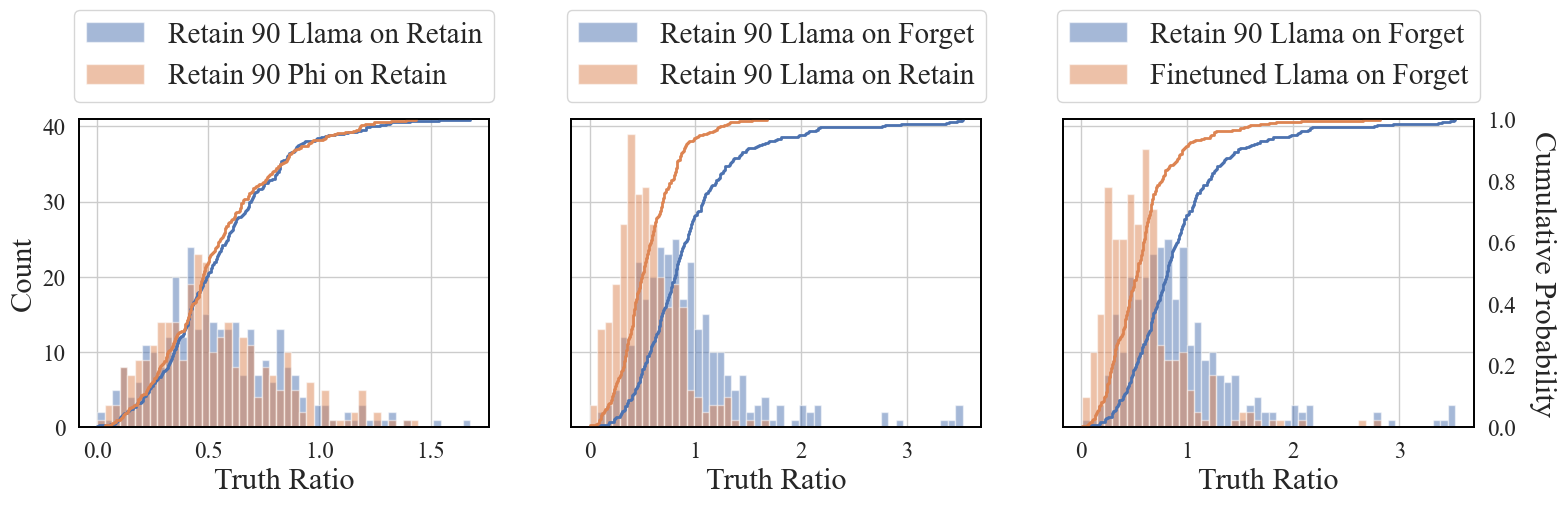

In [10]:
metric = 'truth_ratio'
forget_rate = [90]
fs=22
suffix = ''
for rate in forget_rate:

    llama_forget_out = np.array(list(llama_output[f'retain{rate}']['eval_log_forget.json'][metric].values()))
    # phi_forget_out = np.array(list(phi_output[f'retain{rate}']['eval_log_forget.json'][metric].values()))
    llama_retain_out = np.array(list(llama_output[f'retain{rate}']['eval_log.json'][metric].values()))
    # phi_retain_out = np.array(list(phi_output[f'retain{rate}']['eval_log.json'][metric].values()))

    llama_finetune_retain_out = np.array(list(llama_output['full']['eval_log.json'][metric].values()))
    llama_finetune_forget_out = np.array(list(llama_output['full']['eval_log_forget.json'][metric].values()))

    # todo might be source of discrepancy
    # if metric == 'truth_ratio':
    #     llama_forget_out = llama_forget_out
    #     phi_forget_out = 1/phi_forget_out
    #     llama_retain_out = 1/llama_retain_out
    #     phi_retain_out = 1/phi_retain_out
    #     llama_finetune_retain_out = 1/llama_finetune_retain_out
    #     llama_finetune_forget_out = 1/llama_finetune_forget_out
        


    # plot the distribution of the metric
    fig, axes=plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    ax = axes[0]
    ax2 = axes[2]
    ax5 = axes[1]



    # bins=np.histogram(np.hstack((llama_retain_out, phi_retain_out)), bins=50)[1]

    # ax.hist(llama_retain_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Retain')
    # ax.hist(phi_retain_out, bins=bins, alpha=0.5, label='Retain 90 Phi on Retain')
    # axx = ax.twinx()
    # axx.grid(False)
    # axx.ecdf(llama_retain_out, label='Retain 90 Llama on Retain', linestyle='-', linewidth=2)
    # axx.ecdf(phi_retain_out, label='Retain 90 Phi on Retain', linestyle='-', linewidth=2)

    
    # axx.legend()
    # ax.legend(loc='lower center', fontsize=fs-1, bbox_to_anchor=(0.5, 1.01), ncol=1)

    bins=np.histogram(np.hstack((llama_forget_out, llama_finetune_forget_out)), bins=50)[1]
    ax2.hist(llama_forget_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Forget')
    ax2.hist(llama_finetune_forget_out, bins=bins, alpha=0.5, label='Finetuned Llama on Forget')
    # ax2.sharey(ax)
    axx2 = ax2.twinx()
    # axx2.sharey(axx)

    axx2.grid(False)
    axx2.ecdf(llama_forget_out, label='Retain90 Llama on Forget', linestyle='-', linewidth=2)
    axx2.ecdf(llama_finetune_forget_out, label='Finetuned Llama on Forget', linestyle='-', linewidth=2)
    ax2.set_xlabel('Truth Ratio', fontsize=fs)
    # ax2.set_ylabel('Count')
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    ax2.legend(loc='lower center', fontsize=fs-1, bbox_to_anchor=(0.5, 1.01), ncol=1)

    bins=np.histogram(np.hstack((llama_forget_out, llama_retain_out)), bins=50)[1]
    ax5.hist(llama_forget_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Forget')
    ax5.hist(llama_retain_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Retain')
    axx5 = ax5.twinx()
    axx5.grid(False)
    # ax5.sharey(ax)
    # axx5.sharey(axx)
    ax5.sharey(ax2)
    axx5.sharey(axx2)
    axx5.ecdf(llama_forget_out, label='Retain 90 Llama on Forget', linestyle='-', linewidth=2)
    axx5.ecdf(llama_retain_out, label='Retain 90 Llama on Retain', linestyle='-', linewidth=2)
    ax5.set_xlabel('Truth Ratio', fontsize=fs)
    # ax5.set_ylabel('Count')
    ax5.legend(loc='lower center', fontsize=fs-1, bbox_to_anchor=(0.5, 1.01), ncol=1)

    axx2.set_ylabel('Cumulative Probability', rotation=270, fontsize=fs)
    axx2.yaxis.set_label_coords(1.2, .5)
    axx2.yaxis.set_label_position("right")
    axx2.yaxis.tick_right()
    axx5.yaxis.set_tick_params(labelright=False)
    # axx.yaxis.set_tick_params(labelright=False)

    # ax.set_xlabel('Truth Ratio', fontsize=fs)
    # ax.set_ylabel('Count', fontsize=fs)
    ax.set_xlabel('Truth Ratio', fontsize=fs)
    ax.set_ylabel('Count', fontsize=fs)

    for axi in [ax, ax2, ax5, axx, axx2, axx5]:
        axi.spines['bottom'].set_color('black')
        axi.spines['left'].set_color('black')
        axi.spines['top'].set_color('black')
        axi.spines['right'].set_color('black')
        axi.tick_params(left=False)
        axi.tick_params(right=False)
        # axi.set_xlim(0, 3)


    plt.show()
    # fig.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_1.pdf', bbox_inches='tight', format='pdf')
    # fig2.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_2.pdf', bbox_inches='tight', format='pdf')
    # fig3.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_3.pdf', bbox_inches='tight', format='pdf')
    # fig4.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_4.pdf', bbox_inches='tight', format='pdf')
    # fig5.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_5.pdf', bbox_inches='tight', format='pdf')
    from pathlib import Path 
    Path(f'figure/truth_ratio').mkdir(parents=True, exist_ok=True)
    # fig.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio.pdf', bbox_inches='tight', format='pdf')

    

In [6]:
# a=stats.ks_2samp(llama_retain_out, phi_retain_out)
b=stats.ks_2samp(llama_retain_out, llama_forget_out)
c=stats.ks_2samp(llama_forget_out, llama_finetune_forget_out)
# d=stats.ks_2samp(llama_forget_out, phi_forget_out)
# a,b,c, d
b, c

(KstestResult(statistic=0.056666666666666664, pvalue=0.7220634112888834, statistic_location=0.5083148118411741, statistic_sign=-1),
 KstestResult(statistic=0.38333333333333336, pvalue=4.91499090479225e-20, statistic_location=0.6276966977761961, statistic_sign=1),
 KstestResult(statistic=0.39666666666666667, pvalue=1.834066410994743e-21, statistic_location=0.7165234066802089, statistic_sign=-1),
 KstestResult(statistic=0.09, pvalue=0.17609362474930004, statistic_location=0.6435475430437773, statistic_sign=-1))

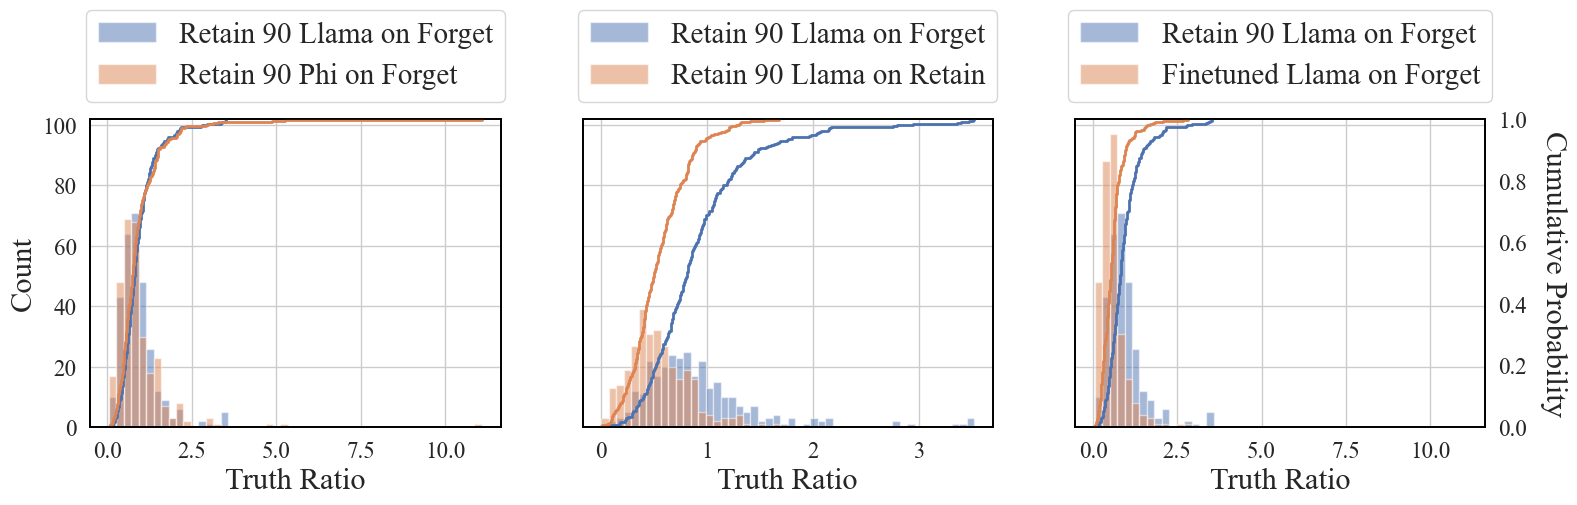

In [11]:
metric = 'truth_ratio'
forget_rate = [90]
fs=22
suffix = ''
for rate in forget_rate:

    llama_forget_out = np.array(list(llama_output[f'retain{rate}']['eval_log_forget.json'][metric].values()))
    # phi_forget_out = np.array(list(phi_output[f'retain{rate}']['eval_log_forget.json'][metric].values()))
    llama_retain_out = np.array(list(llama_output[f'retain{rate}']['eval_log.json'][metric].values()))
    # phi_retain_out = np.array(list(phi_output[f'retain{rate}']['eval_log.json'][metric].values()))

    llama_finetune_retain_out = np.array(list(llama_output['full']['eval_log.json'][metric].values()))
    llama_finetune_forget_out = np.array(list(llama_output['full']['eval_log_forget.json'][metric].values()))



    # plot the distribution of the metric
    fig, axes=plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    ax = axes[0]
    ax2 = axes[2]
    ax5 = axes[1]



    # bins=np.histogram(np.hstack((llama_forget_out, phi_forget_out)), bins=50)[1]
    bins=np.histogram(np.hstack((llama_forget_out)), bins=50)[1]

    ax.hist(llama_forget_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Forget')
    # ax.hist(phi_forget_out, bins=bins, alpha=0.5, label='Retain 90 Phi on Forget')
    axx = ax.twinx()
    axx.grid(False)
    axx.ecdf(llama_forget_out, label='Retain 90 Llama on Retain', linestyle='-', linewidth=2)
    # axx.ecdf(phi_forget_out, label='Retain 90 Phi on Retain', linestyle='-', linewidth=2)

    
    # axx.legend()
    ax.legend(loc='lower center', fontsize=fs-1, bbox_to_anchor=(0.5, 1.01), ncol=1)

    # bins=np.histogram(np.hstack((llama_forget_out, phi_forget_out)), bins=50)[1]
    bins=np.histogram(np.hstack((llama_forget_out)), bins=50)[1]

    ax2.hist(llama_forget_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Forget')
    ax2.hist(llama_finetune_forget_out, bins=bins, alpha=0.5, label='Finetuned Llama on Forget')
    ax2.sharey(ax)
    axx2 = ax2.twinx()
    axx2.sharey(axx)

    axx2.grid(False)
    axx2.ecdf(llama_forget_out, label='Retain90 Llama on Forget', linestyle='-', linewidth=2)
    axx2.ecdf(llama_finetune_forget_out, label='Finetuned Llama on Forget', linestyle='-', linewidth=2)
    ax2.set_xlabel('Truth Ratio', fontsize=fs)
    # ax2.set_ylabel('Count')
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    ax2.legend(loc='lower center', fontsize=fs-1, bbox_to_anchor=(0.5, 1.01), ncol=1)

    bins=np.histogram(np.hstack((llama_forget_out, llama_retain_out)), bins=50)[1]
    ax5.hist(llama_forget_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Forget')
    ax5.hist(llama_retain_out, bins=bins, alpha=0.5, label='Retain 90 Llama on Retain')
    axx5 = ax5.twinx()
    axx5.grid(False)
    ax5.sharey(ax)
    axx5.sharey(axx)
    axx5.ecdf(llama_forget_out, label='Retain 90 Llama on Forget', linestyle='-', linewidth=2)
    axx5.ecdf(llama_retain_out, label='Retain 90 Llama on Retain', linestyle='-', linewidth=2)
    ax5.set_xlabel('Truth Ratio', fontsize=fs)
    # ax5.set_ylabel('Count')
    ax5.legend(loc='lower center', fontsize=fs-1, bbox_to_anchor=(0.5, 1.01), ncol=1)

    axx2.set_ylabel('Cumulative Probability', rotation=270, fontsize=fs)
    axx2.yaxis.set_label_coords(1.2, .5)
    axx2.yaxis.set_label_position("right")
    axx2.yaxis.tick_right()
    axx5.yaxis.set_tick_params(labelright=False)
    axx.yaxis.set_tick_params(labelright=False)

    ax.set_xlabel('Truth Ratio', fontsize=fs)
    ax.set_ylabel('Count', fontsize=fs)

    for axi in [ax, ax2, ax5, axx, axx2, axx5]:
        axi.spines['bottom'].set_color('black')
        axi.spines['left'].set_color('black')
        axi.spines['top'].set_color('black')
        axi.spines['right'].set_color('black')
        axi.tick_params(left=False)
        axi.tick_params(right=False)
        # axi.set_xlim(0, 3)


    plt.show()
    # fig.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_1.pdf', bbox_inches='tight', format='pdf')
    # fig2.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_2.pdf', bbox_inches='tight', format='pdf')
    # fig3.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_3.pdf', bbox_inches='tight', format='pdf')
    # fig4.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_4.pdf', bbox_inches='tight', format='pdf')
    # fig5.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio_5.pdf', bbox_inches='tight', format='pdf')
    from pathlib import Path 
    Path(f'figure/truth_ratio').mkdir(parents=True, exist_ok=True)
    # fig.savefig(f'figure/truth_ratio/forget{rate}_truth_ratio.pdf', bbox_inches='tight', format='pdf')

    